# Exploratory Data Analysis - Building data

## 1. Loading packages and libraries

We'll start by importing the necessary packages

In [6]:
# For data manipulation
import pandas as pd
import numpy as np

# For visualisations
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# For UML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 2. Loading data

This dataset contains data from one sensor installed at an electric charger spot.

The information received about the columns are the following:
*	**Time:** Time of measurement
*	**Battery:** Battery voltage at packet transmission (the nominal voltage of the battery package is 3V, and the capacity is 6AH)
*   **Temperature:** Calibrates the magnetic field readings, which are highly dependent on the temperature
*	**X:** Magnetic field reading in the x direction
*	**Y:** Magnetic field reading in the y direction
*	**Z:** Magnetic field reading in the z direction
*   **Radar data:**
    *   **0_radar:** Signal reflection strength in the 20 – 27.5 cm
    *	**1_radar:** Signal reflection strength in the 27.5 – 35 cm
    *	**2_radar:** Signal reflection strength in the 35 – 42.5 cm
    *	**3_radar:** Signal reflection strength in the 42.5 – 50 cm
    *	**4_radar:** Signal reflection strength in the 50 – 57.5 cm
    *	**5_radar:** Signal reflection strength in the 57.5 – 65 cm
    *	**6_radar:** Signal reflection strength in the 65 – 72.5 cm
    *	**7_radar:** Signal reflection strength in the 72.5 – 80 cm
*	**Package_type:**
    *	**PackageType.CHANGE =** A big change in magnetic field is detected. The magnetic field coordinates (x, y and z) need to change by 30 points on at least 1 axis, to be classified as a CHANGE packet.
    *	**PackageType.HEART_BEAT =** Regular heartbeat if no major changes in magnetic field are detected
*	**f_cnt:** The number of packages transmitted since last network registration
*	**dr:** Data rate parameter in LoRaWAN. It ranges between 1 and 5 where 1 is the slowest transmission data rate and 5 is the highest. This datarate is scaled by the network server depending on the signal quality of the past packages send.
*	**SNR:** Signal to noise ratio – the higher value, the better the signal quality
*	**RSSI:** Signal strength – the higher value, the better the signal quality

In [7]:
# Loading the data
df = pd.read_csv('/work/MLOps_Project/notebooks/building_historic_data.csv') # The path to the dataset should probably be changed when we're setting up the serverless-ml-pipeline
df.head()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,package_type,f_cnt,dr,snr,rssi,hw_fw_version
0,2024-03-01 00:03:31.999000,NaN,5.500,312,-465,-991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1510,5,1.8,-89,DataVersion.HW_2FW2_X_X
1,2024-03-01 00:13:30.999000,NaN,5.500,309,-463,-992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1510,5,1.8,-89,DataVersion.HW_2FW2_X_X
2,2024-03-01 00:23:31.999000,3.16,5.375,312,-466,-987,4.0,5.0,6.0,6.0,4.0,6.0,6.0,5.0,PackageType.HEART_BEAT,1510,5,1.8,-89,DataVersion.HW_2FW2_X_X
3,2024-03-01 00:33:33.017000,NaN,5.375,312,-464,-997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1511,5,1.2,-89,DataVersion.HW_2FW2_X_X
4,2024-03-01 00:43:33.017000,NaN,5.375,310,-467,-993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PackageType.HEART_BEAT,1511,5,1.2,-89,DataVersion.HW_2FW2_X_X


## 3. Checking for missing values and duplicates

In [8]:
# Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7164 entries, 0 to 7163
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           7164 non-null   object 
 1   battery        2512 non-null   float64
 2   temperature    7164 non-null   float64
 3   x              7164 non-null   int64  
 4   y              7164 non-null   int64  
 5   z              7164 non-null   int64  
 6   0_radar        2512 non-null   float64
 7   1_radar        2512 non-null   float64
 8   2_radar        2512 non-null   float64
 9   3_radar        2512 non-null   float64
 10  4_radar        2512 non-null   float64
 11  5_radar        2512 non-null   float64
 12  6_radar        2512 non-null   float64
 13  7_radar        2512 non-null   float64
 14  package_type   7164 non-null   object 
 15  f_cnt          7164 non-null   int64  
 16  dr             7164 non-null   int64  
 17  snr            7117 non-null   float64
 18  rssi    

In [9]:
# Convert the 'time' column to datetime, coercing errors to NaT
df['time'] = pd.to_datetime(df['time'], errors='coerce')
# Remove rows where the 'time' column is NaT
df = df.dropna(subset=['time'])

# Checking the datatype of each column again
df.dtypes

time             datetime64[ns]
battery                 float64
temperature             float64
x                         int64
y                         int64
z                         int64
0_radar                 float64
1_radar                 float64
2_radar                 float64
3_radar                 float64
4_radar                 float64
5_radar                 float64
6_radar                 float64
7_radar                 float64
package_type             object
f_cnt                     int64
dr                        int64
snr                     float64
rssi                      int64
hw_fw_version            object
dtype: object

We can see that the 'time' variable has changed from object to datetime64

In [10]:
# Checking how the time column looks now
df['time'].head()

0   2024-03-01 00:03:31.999
1   2024-03-01 00:13:30.999
2   2024-03-01 00:23:31.999
3   2024-03-01 00:33:33.017
4   2024-03-01 00:43:33.017
Name: time, dtype: datetime64[ns]

Now we'll check for any duplicated rows in the dataset

In [11]:
# Checking if there are any duplicated rows
num_duplicate_rows = df.duplicated().sum()
print("Number of duplicated rows: ", num_duplicate_rows)

Number of duplicated rows:  0


This tells us that there are no duplicated rows.

We'll also check the number of unique values in each column:

In [12]:
# Checking the number of unique values in each column
df.nunique()

time             7155
battery             4
temperature       296
x                 653
y                 524
z                 892
0_radar           110
1_radar           112
2_radar            84
3_radar            85
4_radar            79
5_radar            48
6_radar            44
7_radar            42
package_type        2
f_cnt            2508
dr                  1
snr                80
rssi               29
hw_fw_version       1
dtype: int64

## 4. Feature Engineering

Before starting on the EDA, we'll make some extra features in order to get more information about the data.

In [13]:
# Making a new column including only the date from the 'time' variable
df['date'] = df['time'].dt.date

In [14]:
# Making a new column including only the hour from the 'time' variable
df['hour'] = df['time'].dt.hour

In [15]:
# Making a new column including the day of week from the 'time' variable
df['day_of_week'] = df['time'].dt.dayofweek

# And another column containing the name of the day
df['day_name'] = df['time'].dt.day_name()

In [16]:
# Checking how these new variables look
df[['time','date', 'hour', 'day_of_week', 'day_name']].sample(10)

,time,date,hour,day_of_week,day_name
2975,2024-03-26 12:58:01.290,2024-03-26,12,1,Tuesday
55,2024-03-01 09:48:06.837,2024-03-01,9,4,Friday
5783,2024-04-19 17:03:23.428,2024-04-19,17,4,Friday
6165,2024-04-22 12:01:30.701,2024-04-22,12,0,Monday
5339,2024-04-16 09:05:17.259,2024-04-16,9,1,Tuesday
2035,2024-03-18 19:38:15.610,2024-03-18,19,0,Monday
3935,2024-04-03 22:00:22.201,2024-04-03,22,2,Wednesday
1769,2024-03-16 19:01:44.349,2024-03-16,19,5,Saturday
1568,2024-03-15 03:19:19.218,2024-03-15,3,4,Friday
2225,2024-03-20 14:54:33.423,2024-03-20,14,2,Wednesday


## 5. Exploratory Data Analysis

Now we'll start on the EDA. Firstly, we'll look at the descriptive statistics for all of the numeric columns. For this we'll use the pandas describe command.

In [17]:
# Generating descriptive statistics
df.describe()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,4_radar,5_radar,6_radar,7_radar,f_cnt,dr,snr,rssi,hour,day_of_week
count,7155,2509.000000,7155.000000,7155.000000,7155.000000,7155.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,7155.000000,7155.0,7108.000000,7155.000000,7155.000000,7155.000000
mean,2024-03-31 16:13:38.837857792,3.167286,8.119427,299.372746,-413.790217,-853.986024,13.639697,14.143882,12.314069,11.246313,10.084894,8.519729,7.437226,6.710642,3085.131377,5.0,3.515166,-83.822502,11.860517,3.072397
min,2024-03-01 00:03:31.999000,3.140000,-1.750000,-232.000000,-1112.000000,-1648.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1510.000000,5.0,-9.500000,-98.000000,0.000000,0.000000
25%,2024-03-16 22:16:41.380000,3.160000,4.875000,263.000000,-474.000000,-988.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2328.000000,5.0,0.800000,-87.000000,5.000000,1.000000
50%,2024-03-30 23:08:01.255000064,3.160000,7.000000,308.000000,-467.000000,-904.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,3041.000000,5.0,4.800000,-84.000000,12.000000,3.000000
75%,2024-04-16 16:14:27.799000064,3.180000,9.875000,348.000000,-459.000000,-797.000000,8.000000,6.000000,6.000000,6.000000,6.000000,7.000000,6.000000,6.000000,3901.500000,5.0,7.000000,-80.000000,18.000000,5.000000
max,2024-04-29 23:58:31.717000,3.200000,38.750000,909.000000,435.000000,226.000000,160.000000,170.000000,143.000000,110.000000,100.000000,51.000000,53.000000,51.000000,4596.000000,5.0,10.800000,-70.000000,23.000000,6.000000
std,NaN,0.010857,5.650455,108.402764,200.540056,231.751742,20.141389,22.197991,16.916444,14.912581,12.637646,7.842251,5.967060,4.654829,902.610305,0.0,4.571675,5.052625,7.189017,2.034044


Next we'll check the number of datapoints each day

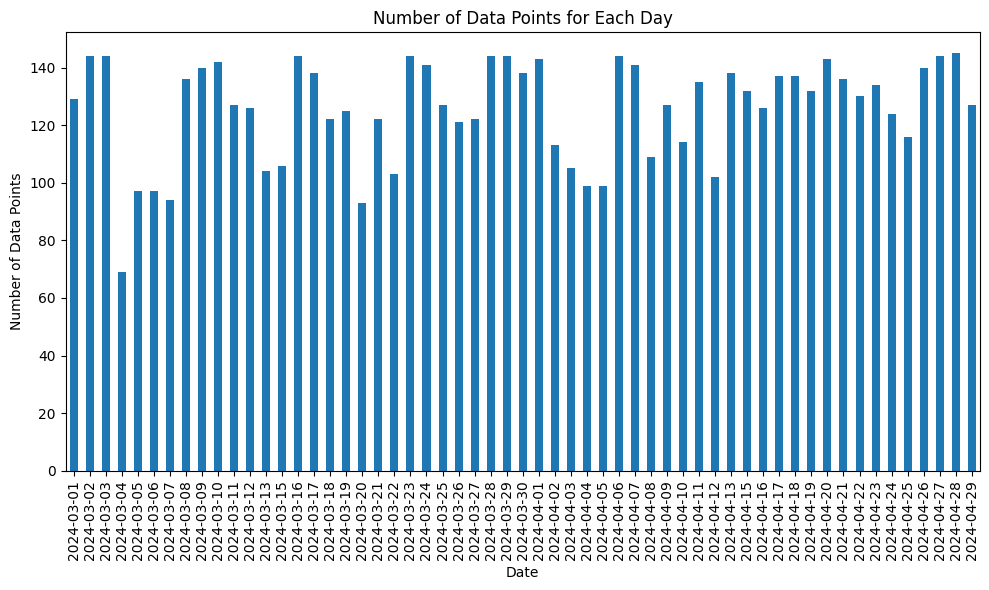

In [18]:
# Grouping by date and counting the number of data points
daily_counts = df.groupby('date').size()

# Plotting the number of data points for each day using plt
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar')
plt.title('Number of Data Points for Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Package type variable

Next we'll look at the package type variable. Firstly we'll check which unique values the variable contains.

In [19]:
# Checking the unique values in package type
df['package_type'].unique()

array(['PackageType.HEART_BEAT', 'PackageType.CHANGE'], dtype=object)

We now know that the variable contains two unique values; Package.Type.CHANGE and PackageType.HEART_BEAT.

From the information about the dataset we know that CHANGE is used for datapoints where a big change in magnetic field is detected and HEART_BEAT is used when there is no major changes in the magnetic field.

We can check the distribution of these two package types.

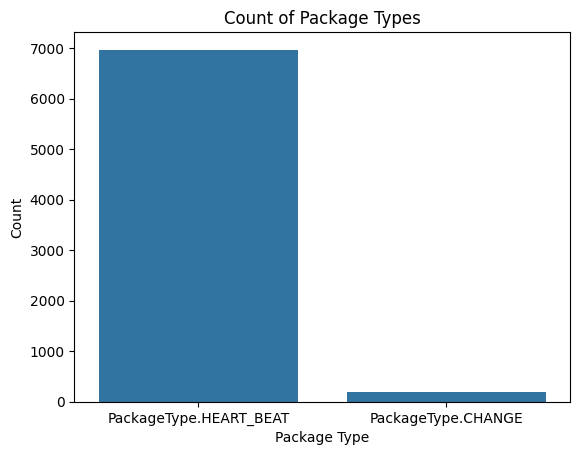

In [20]:
# Plotting the distribution of package types
plt.figure()
sns.countplot(data=df, x='package_type')
plt.title('Count of Package Types')
plt.xlabel('Package Type')
plt.ylabel('Count')
plt.show()

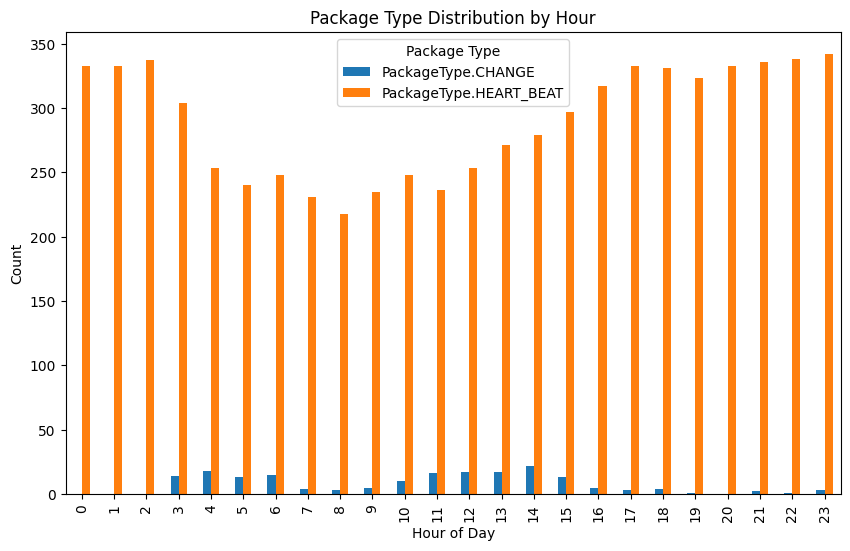

In [21]:
# Grouping the package type based on hour
hourly_counts = df.groupby(['hour', 'package_type']).size().unstack(fill_value=0)

# Plotting the package type distribution by hour
hourly_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Package Type Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title='Package Type')
plt.show()

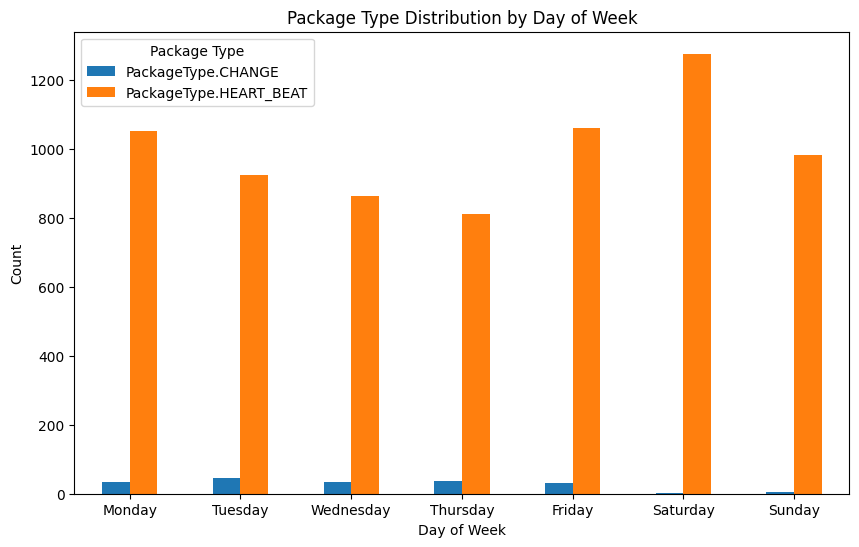

In [22]:
# Grouping the package type based on day of week
day_of_week_counts = df.groupby(['day_name', 'package_type']).size().unstack(fill_value=0)

# Specifying the order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reordering the index based on the specified day order
day_of_week_counts = day_of_week_counts.reindex(day_order)

# Plotting the package type distribution by day of week
day_of_week_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Package Type Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Package Type')
plt.xticks(rotation=0)
plt.show()

We would also like to know how long the car is parked on average.

In [23]:
# Creating two new dataframes. The first dataframe is filtered to only include PackageType.CHANGE events and the second dataframe wil only include PackageType.HEART_BEAT
changes = df[df['package_type'] == 'PackageType.CHANGE']
heart_beats = df[df['package_type'] == 'PackageType.HEART_BEAT']

In [24]:
# Calculating parking duration for each change
changes = changes.copy()  # Creating a copy of the dataframe to get rid of warnings
changes['parking_duration'] = changes['time'].diff()

# Calculating the average parking duration
average_parking_duration = changes['parking_duration'].mean()

print("Average parking duration:", average_parking_duration)

Average parking duration: 0 days 07:41:44.745270270


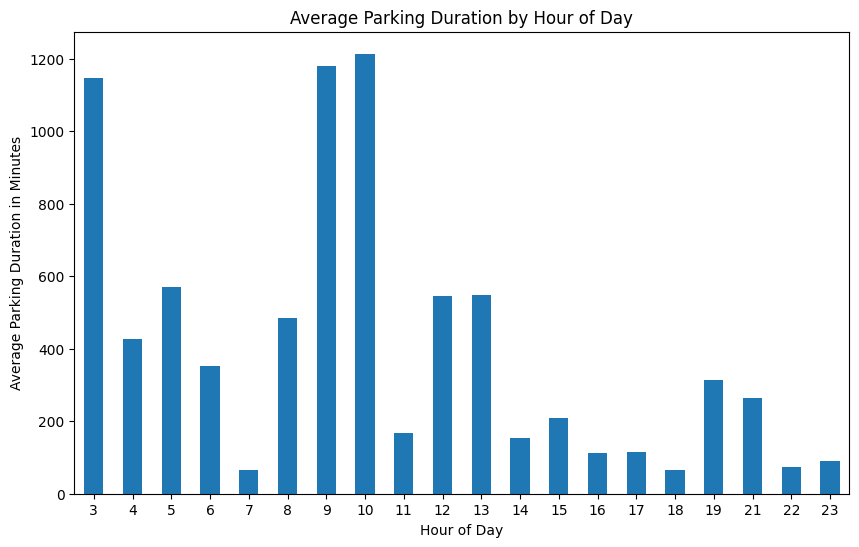

In [25]:
# Calculating parking duration in minutes for each change
changes['parking_duration_minutes'] = changes['parking_duration'].dt.total_seconds() / 60

# Grouping by hour and calculating the mean parking duration in minutes
hourly_avg_parking_duration = changes.groupby('hour')['parking_duration_minutes'].mean()

# Plotting the average parkign duration by hour of day
plt.figure(figsize=(10, 6))
hourly_avg_parking_duration.plot(kind='bar')
plt.title('Average Parking Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Parking Duration in Minutes')
plt.xticks(rotation=0)
plt.show()

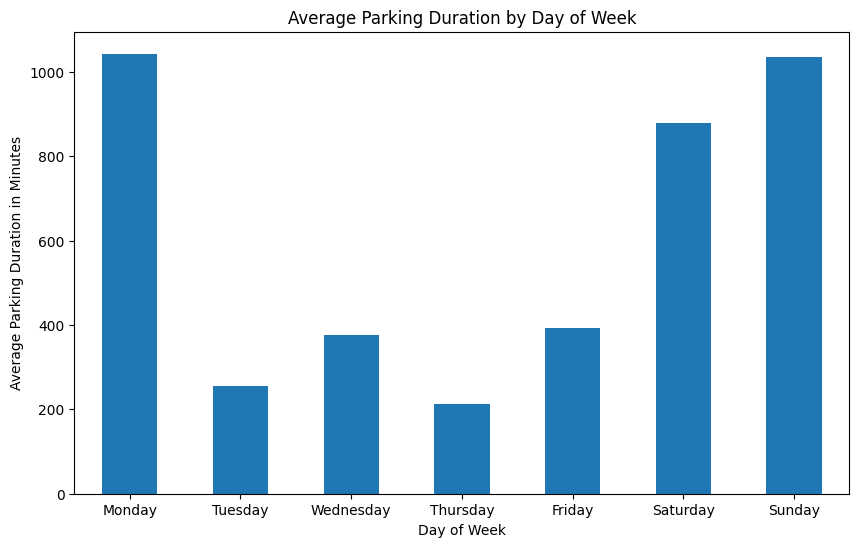

In [26]:
# Grouping by hour and calculating the mean parking duration in minutes
daily_avg_parking_duration = changes.groupby('day_name')['parking_duration_minutes'].mean()

# Reordering the index based on the specified day order from before
daily_avg_parking_duration = daily_avg_parking_duration.reindex(day_order)

# Plotting the average parkign duration by hour of day
plt.figure(figsize=(10, 6))
daily_avg_parking_duration.plot(kind='bar')
plt.title('Average Parking Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Parking Duration in Minutes')
plt.xticks(rotation=0)
plt.show()

Correlation between package type and magnetic field

In [27]:
# Convert 'package_type' to numeric codes
df['package_type_encoded'] = pd.Categorical(df['package_type']).codes
df['package_type_encoded'].head()

0    1
1    1
2    1
3    1
4    1
Name: package_type_encoded, dtype: int8

PackageType.CHANGE is now represented by 0 and PackageType.HEART_BEAT is represented by 1

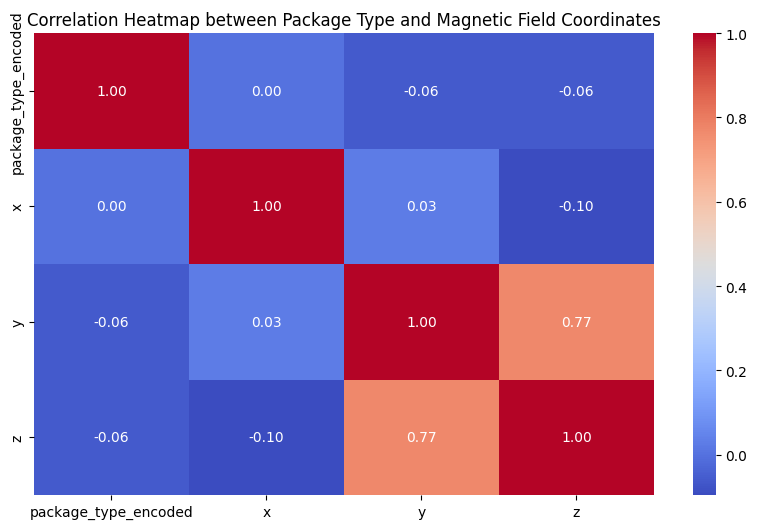

In [28]:
# Calculating correlation matrix
correlation_matrix = df[['package_type_encoded', 'x', 'y', 'z']].corr()

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Package Type and Magnetic Field Coordinates')
plt.show()

Before going on to the next variable, we'll look at how much x, y and z need to change in order for the package type to change from HEART_BEAT to CHANGE.

In [29]:
df_package_diff = df[['time', 'x', 'y', 'z', 'package_type']]
df_package_diff = df_package_diff.copy() # Making a copy of the dataframe to get rid of warnings
df_package_diff['x_diff'] = df_package_diff['x'].diff()
df_package_diff['y_diff'] = df_package_diff['y'].diff()
df_package_diff['z_diff'] = df_package_diff['z'].diff()
df_package_diff.head()

,time,x,y,z,package_type,x_diff,y_diff,z_diff
0,2024-03-01 00:03:31.999,312,-465,-991,PackageType.HEART_BEAT,NaN,NaN,NaN
1,2024-03-01 00:13:30.999,309,-463,-992,PackageType.HEART_BEAT,-3.0,2.0,-1.0
2,2024-03-01 00:23:31.999,312,-466,-987,PackageType.HEART_BEAT,3.0,-3.0,5.0
3,2024-03-01 00:33:33.017,312,-464,-997,PackageType.HEART_BEAT,0.0,2.0,-10.0
4,2024-03-01 00:43:33.017,310,-467,-993,PackageType.HEART_BEAT,-2.0,-3.0,4.0


In [30]:
x_average_diff = df_package_diff.groupby('package_type')['x_diff'].apply(lambda x: x.abs().mean())
x_average_diff

package_type
PackageType.CHANGE        109.145161
PackageType.HEART_BEAT      5.258037
Name: x_diff, dtype: float64

In [31]:
y_average_diff = df_package_diff.groupby('package_type')['y_diff'].apply(lambda x: x.abs().mean())
y_average_diff

package_type
PackageType.CHANGE        298.360215
PackageType.HEART_BEAT      4.225316
Name: y_diff, dtype: float64

In [32]:
z_average_diff = df_package_diff.groupby('package_type')['z_diff'].apply(lambda x: x.abs().mean())
z_average_diff

package_type
PackageType.CHANGE        275.806452
PackageType.HEART_BEAT      6.513203
Name: z_diff, dtype: float64

### SNR

Signal to noise ratio – the higher value, the better the signal quality

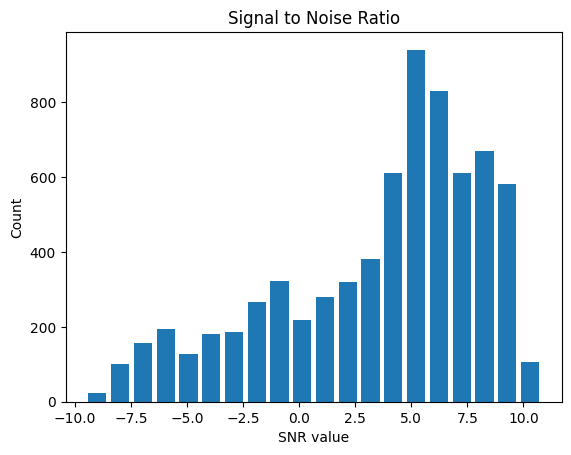

In [33]:
plt.hist(df['snr'], bins =20, histtype='bar', rwidth=0.8)
plt.title('Signal to Noise Ratio')
plt.xlabel('SNR value')
plt.ylabel('Count')
plt.show()

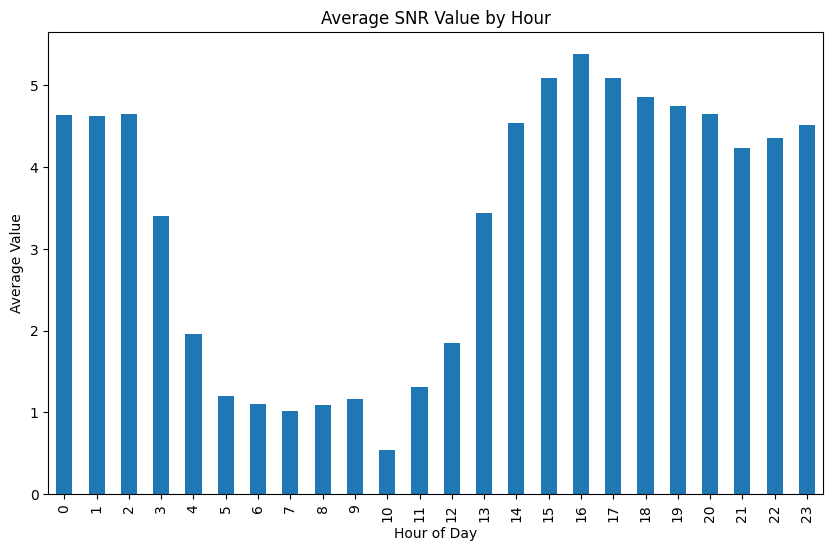

In [34]:
# Grouping the mean SNR value by hour
hourly_mean_snr = df.groupby('hour')['snr'].mean()

# Plotting
hourly_mean_snr.plot(kind='bar', figsize=(10, 6))
plt.title('Average SNR Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()

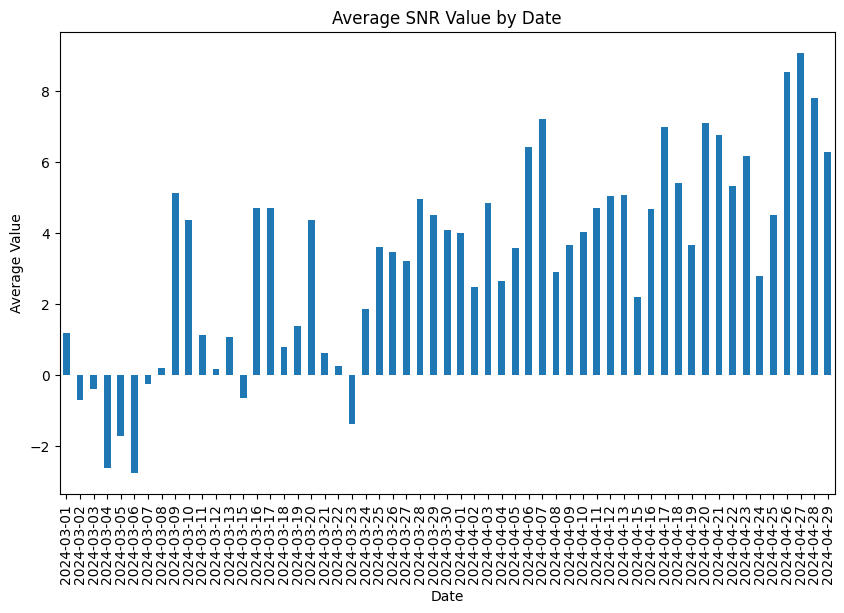

In [35]:
# Grouping the mean SNR value by date
daily_mean_snr = df.groupby('date')['snr'].mean()

# Plotting
daily_mean_snr.plot(kind='bar', figsize=(10, 6))
plt.title('Average SNR Value by Date')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.show()

### RSSI

Signal strength – the higher value, the better the signal quality

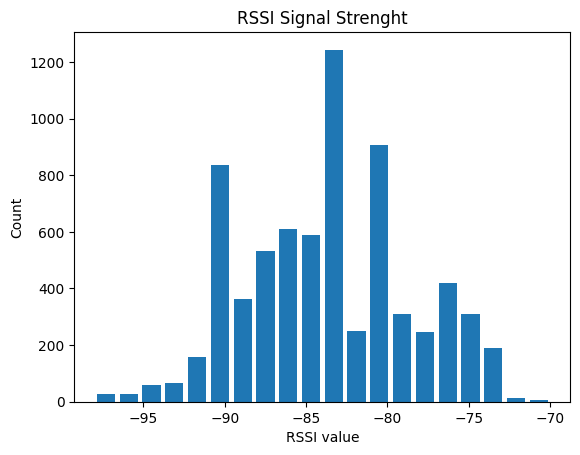

In [36]:
plt.hist(df['rssi'], bins =20, histtype='bar', rwidth=0.8)
plt.title('RSSI Signal Strenght')
plt.xlabel('RSSI value')
plt.ylabel('Count')
plt.show()

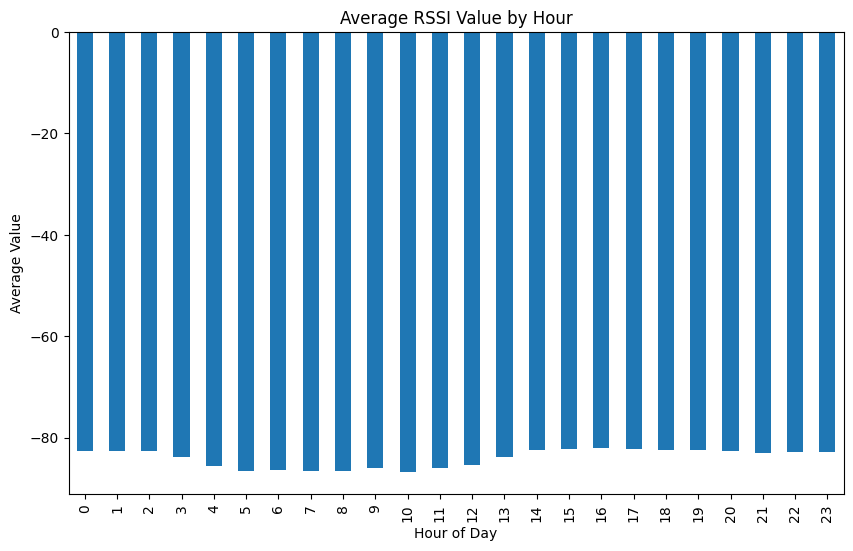

In [37]:
# Grouping the mean RSSI value by hour
hourly_mean_rssi = df.groupby('hour')['rssi'].mean()

# Plotting
hourly_mean_rssi.plot(kind='bar', figsize=(10, 6))
plt.title('Average RSSI Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()

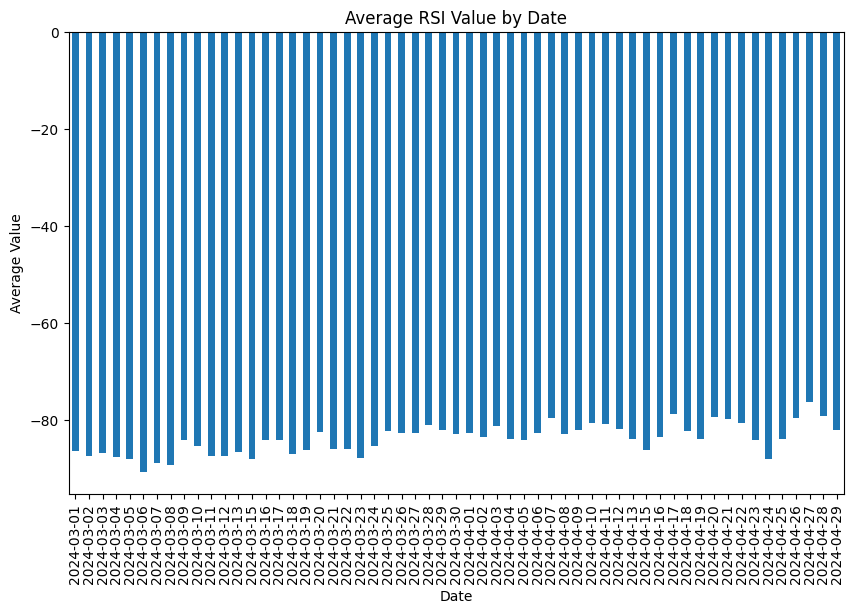

In [38]:
# Grouping the mean SNR value by hour
daily_mean_rssi = df.groupby('date')['rssi'].mean()

# Plotting
daily_mean_rssi.plot(kind='bar', figsize=(10, 6))
plt.title('Average RSI Value by Date')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.show()

### Battery variable

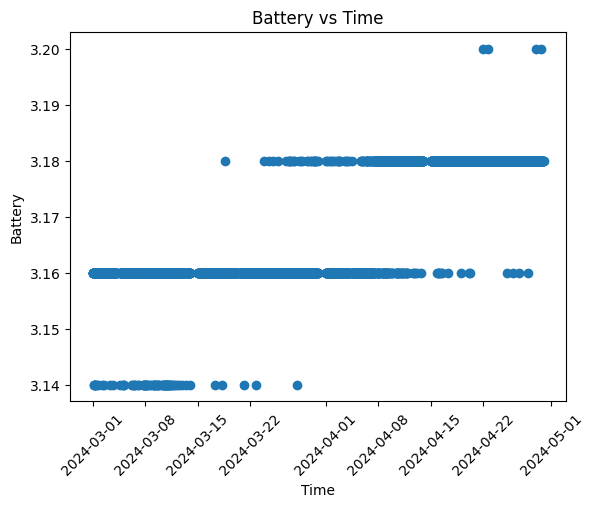

In [39]:
# here I want to plot variable 'battery':
plt.figure()
plt.scatter(x=df["time"] , y=df["battery"])
plt.title('Battery vs Time')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Battery')
plt.show()

### Temperature

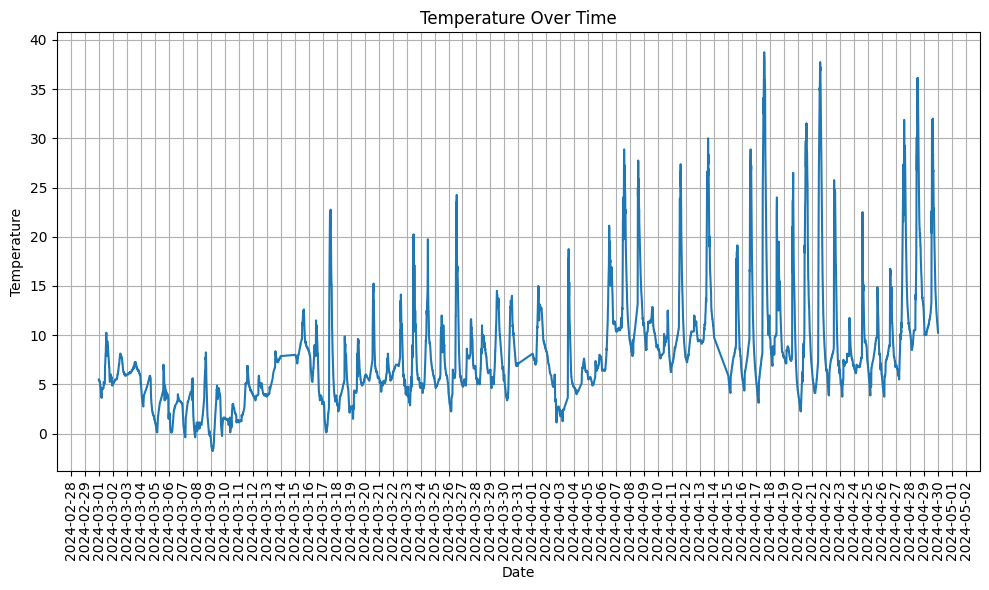

In [40]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['temperature'], linestyle='-')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.grid(True)

# Set x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

In [41]:
# Creating a new dataset including only time and temperature
df_temperature = df[["time", "temperature"]]

# Setting the datetime variable as index
df_temperature = df_temperature.set_index(['time'])
df_temperature.head()

,temperature
time,
2024-03-01 00:03:31.999,5.500
2024-03-01 00:13:30.999,5.500
2024-03-01 00:23:31.999,5.375
2024-03-01 00:33:33.017,5.375
2024-03-01 00:43:33.017,5.375


In [42]:
# Resampling the temperature dataset on hour
df_temperature_hourly = df_temperature.resample("H").mean()
df_temperature_hourly.head()

,temperature
time,
2024-03-01 00:00:00,5.416667
2024-03-01 01:00:00,5.270833
2024-03-01 02:00:00,4.916667
2024-03-01 03:00:00,4.312500
2024-03-01 04:00:00,3.775000


In [43]:
# Plotting the average temperature each hour
alt.Chart((df_temperature_hourly).reset_index()).mark_rect().encode(
    alt.X('hoursminutes(time):O', title='hour of day'),
    alt.Y('monthdate(time):O', title='date'),
    alt.Color('temperature:Q', title='temperature')
)

alt.Chart(...)

# X over time

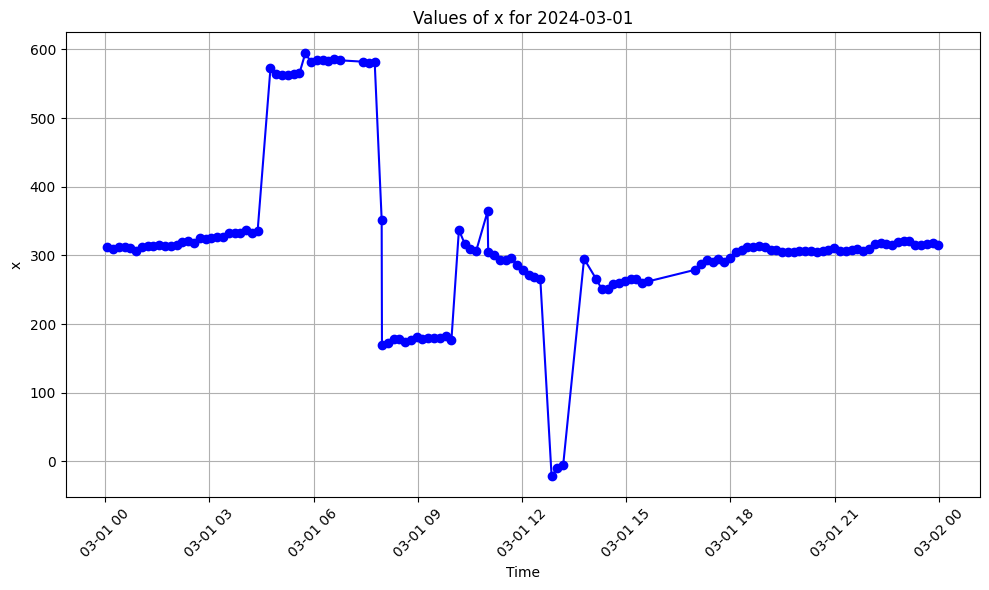

In [61]:
specific_date = '2024-03-01'  # Example date

# Filter the DataFrame for the specific date
df_specific_date = df[df['time'].dt.date == pd.to_datetime(specific_date).date()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_date['time'], df_specific_date['x'], color='blue', marker='o', linestyle='-')
plt.title(f'Values of x for {specific_date}')
plt.xlabel('Time')
plt.ylabel('x')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

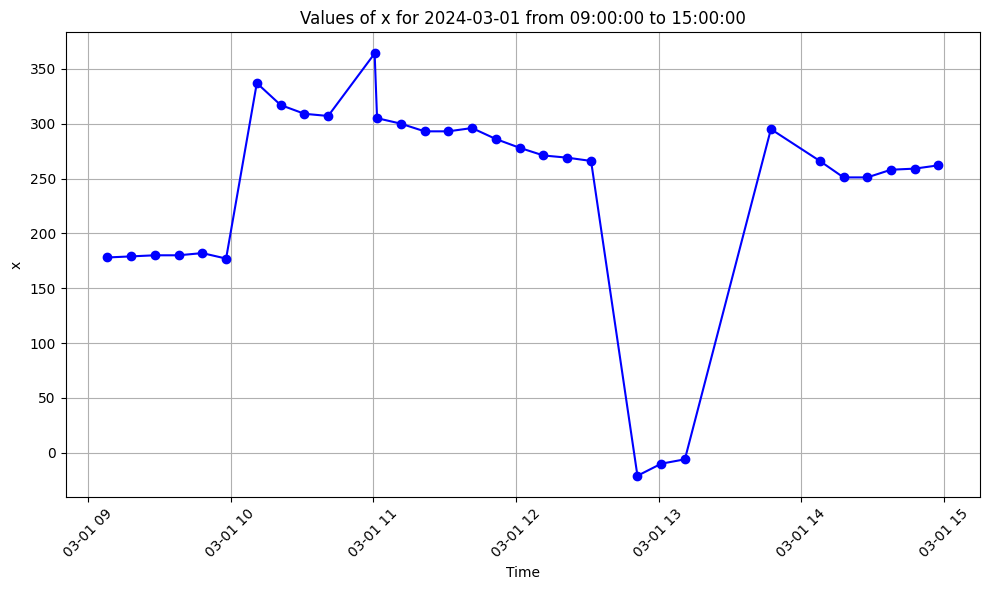

In [45]:
# Convert 'time' column to datetime if it's not already in datetime format
df['time'] = pd.to_datetime(df['time'])

# Specify the date and time range
specific_date = '2024-03-01'
start_time = '09:00:00'
end_time = '15:00:00'

# Filter the DataFrame for the specific date and time range
df_specific_time_range = df[(df['time'].dt.date == pd.to_datetime(specific_date).date()) &
                            (df['time'].dt.time >= pd.to_datetime(start_time).time()) &
                            (df['time'].dt.time <= pd.to_datetime(end_time).time())]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_time_range['time'], df_specific_time_range['x'], color='blue', marker='o', linestyle='-')
plt.title(f'Values of x for {specific_date} from {start_time} to {end_time}')
plt.xlabel('Time')
plt.ylabel('x')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

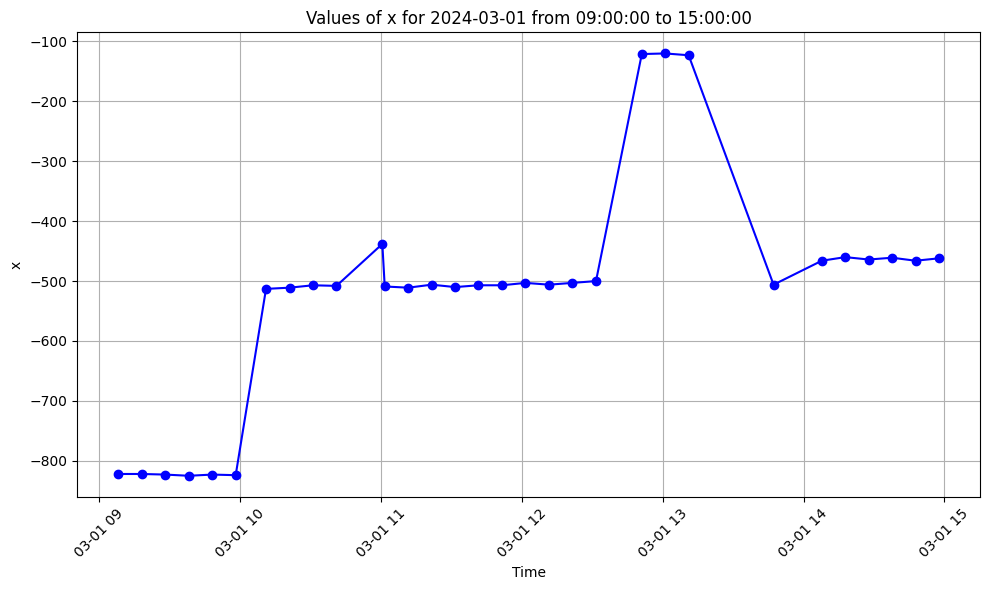

In [46]:
# Convert 'time' column to datetime if it's not already in datetime format
df['time'] = pd.to_datetime(df['time'])

# Specify the date and time range
specific_date = '2024-03-01'
start_time = '09:00:00'
end_time = '15:00:00'

# Filter the DataFrame for the specific date and time range
df_specific_time_range = df[(df['time'].dt.date == pd.to_datetime(specific_date).date()) &
                            (df['time'].dt.time >= pd.to_datetime(start_time).time()) &
                            (df['time'].dt.time <= pd.to_datetime(end_time).time())]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_time_range['time'], df_specific_time_range['y'], color='blue', marker='o', linestyle='-')
plt.title(f'Values of x for {specific_date} from {start_time} to {end_time}')
plt.xlabel('Time')
plt.ylabel('x')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

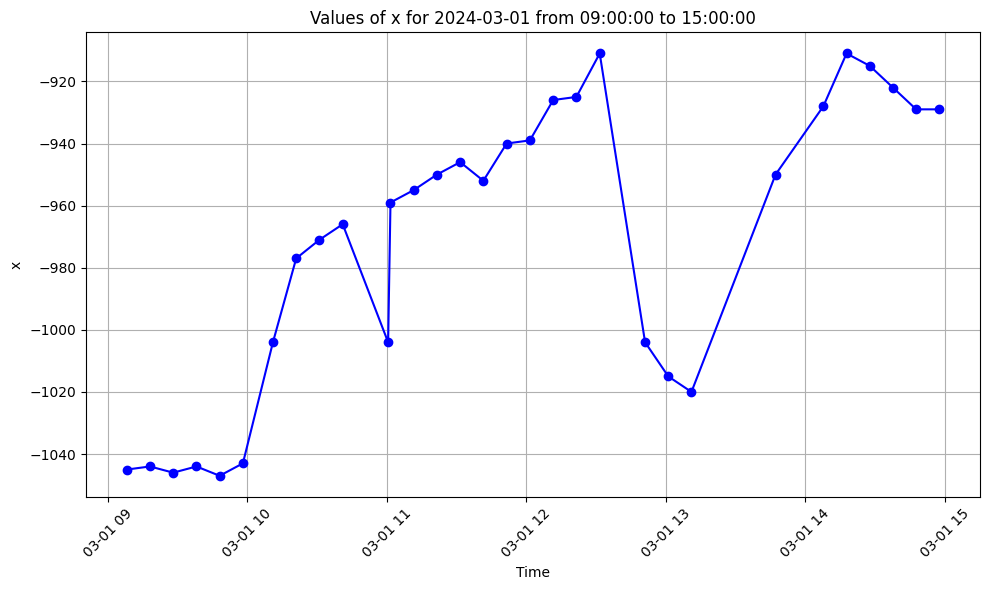

In [47]:
# Convert 'time' column to datetime if it's not already in datetime format
df['time'] = pd.to_datetime(df['time'])

# Specify the date and time range
specific_date = '2024-03-01'
start_time = '09:00:00'
end_time = '15:00:00'

# Filter the DataFrame for the specific date and time range
df_specific_time_range = df[(df['time'].dt.date == pd.to_datetime(specific_date).date()) &
                            (df['time'].dt.time >= pd.to_datetime(start_time).time()) &
                            (df['time'].dt.time <= pd.to_datetime(end_time).time())]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_time_range['time'], df_specific_time_range['z'], color='blue', marker='o', linestyle='-')
plt.title(f'Values of x for {specific_date} from {start_time} to {end_time}')
plt.xlabel('Time')
plt.ylabel('x')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Normalizing the data
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df[['x', 'y', 'z']])

/tmp/ipykernel_18886/3195265455.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific_time_range[['x', 'y', 'z']] = normalized_data


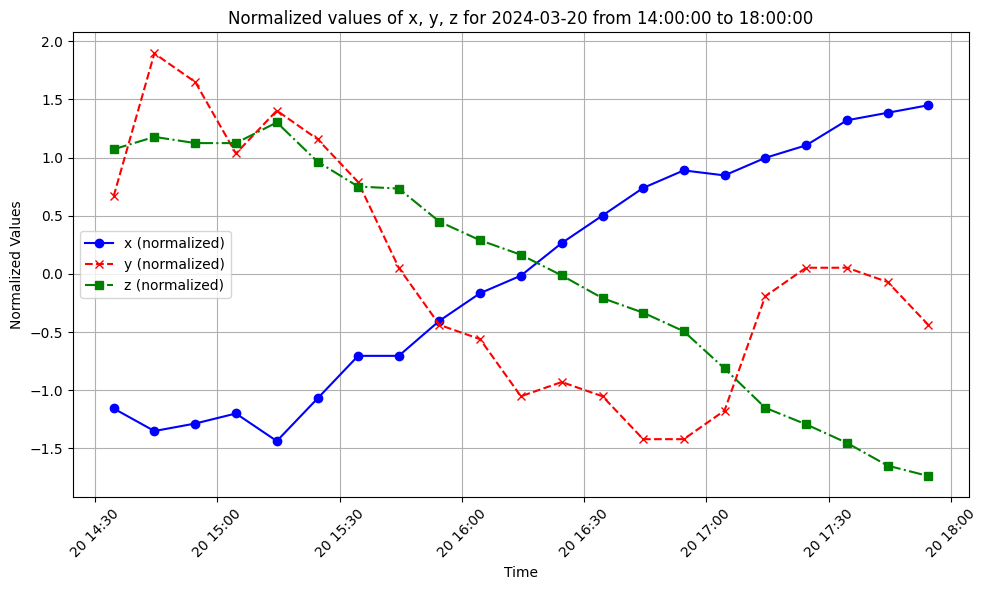

In [49]:
# Convert 'time' column to datetime if it's not already in datetime format
df['time'] = pd.to_datetime(df['time'])

# Specify the date and time range
specific_date = '2024-03-20'
start_time = '14:00:00'
end_time = '18:00:00'

# Filter the DataFrame for the specific date and time range
df_specific_time_range = df[(df['time'].dt.date == pd.to_datetime(specific_date).date()) &
                            (df['time'].dt.time >= pd.to_datetime(start_time).time()) &
                            (df['time'].dt.time <= pd.to_datetime(end_time).time())]

# Selecting the columns to be normalized
data_to_normalize = df_specific_time_range[['x', 'y', 'z']]

# Applying StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_normalize)

# Adding normalized data back to the DataFrame
df_specific_time_range[['x', 'y', 'z']] = normalized_data

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_specific_time_range['time'], df_specific_time_range['x'], label='x (normalized)', color='blue', marker='o', linestyle='-')
plt.plot(df_specific_time_range['time'], df_specific_time_range['y'], label='y (normalized)', color='red', marker='x', linestyle='--')
plt.plot(df_specific_time_range['time'], df_specific_time_range['z'], label='z (normalized)', color='green', marker='s', linestyle='-.')
plt.title(f'Normalized values of x, y, z for {specific_date} from {start_time} to {end_time}')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 5. Unsupervised Machine Learning

### 5.1 UML: Magnetic field data

In this section we'll...

In [50]:
# Saving the magnetic field data in a new dataframe 
mag = df[["x","y","z"]]

In [51]:
# Normalizing the data
scaler = StandardScaler()
mag_normalized = scaler.fit_transform(mag)

In [52]:
print(mag_normalized)

[[ 0.11649275 -0.25537722 -0.59125144]
 [ 0.08881625 -0.24540345 -0.59556671]
 [ 0.11649275 -0.2603641  -0.57399039]
 ...
 [ 0.02423773 -0.35511489  0.4271508 ]
 [ 0.07959074 -0.35511489  0.43578133]
 [ 0.07036524 -0.34015424  0.41852027]]


In [53]:
# Clustering the magnetic field data
kmeans = KMeans(n_clusters=2, random_state=0).fit(mag_normalized)

# Adding cluster labels to the mag dataframe
mag['mag_cluster'] = kmeans.labels_

# Checking the result
mag.sample(5)

/tmp/ipykernel_18886/64798676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag['mag_cluster'] = kmeans.labels_


,x,y,z,mag_cluster
5018,278,-472,-859,0
6244,378,-485,-894,0
3412,281,-462,-911,0
1238,531,207,-341,1
6894,299,-481,-759,0


<BarContainer object of 2 artists>

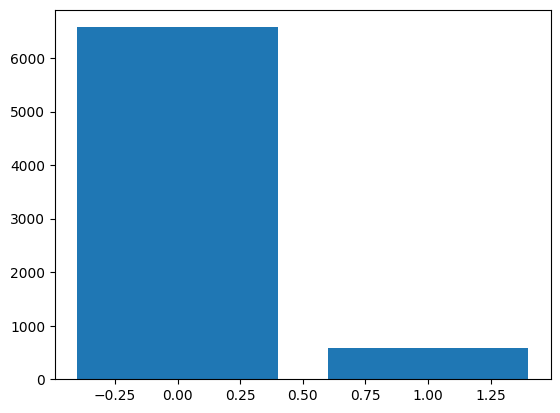

In [54]:
# Checking distribution of different values in mag_cluster values in barplot   
plt.bar(np.arange(2), mag['mag_cluster'].value_counts().values, align='center') # plot histogram for x and y data

**Silhouette score**

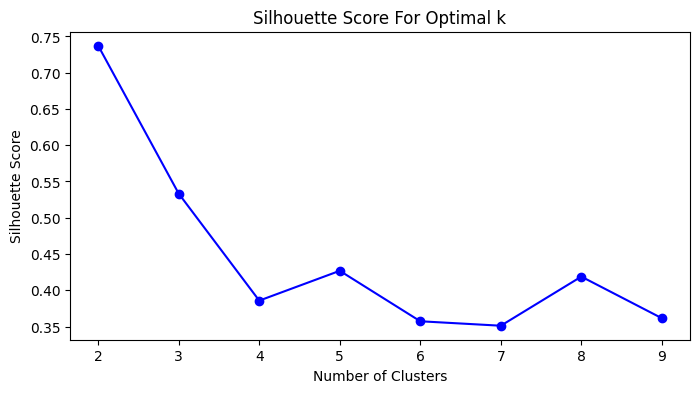

In [55]:
silhouette_avg = []
for k in range(2, 10):  # Starts from 2 clusters 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(mag_normalized, cluster_labels))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_avg, 'bo-')  # Adjust the range as needed
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

**Elbow method**

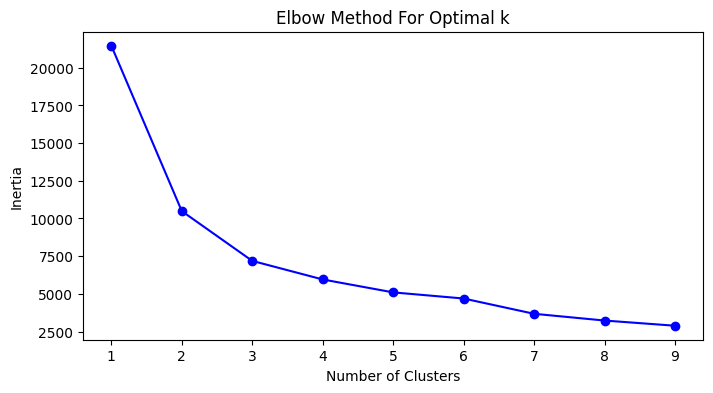

In [56]:
inertia = []
for k in range(1, 10):  
    kmeans = KMeans(n_clusters=k, random_state=0).fit(mag_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, 'bo-') 
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

**Visualising the clusters**

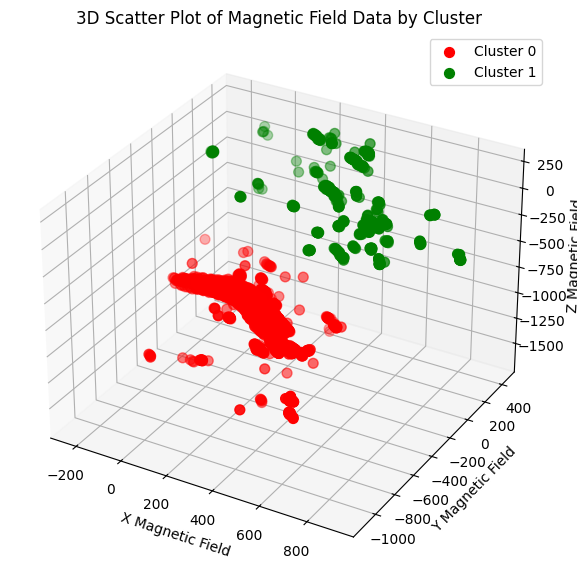

In [57]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# List of colors, ensure you have enough colors for your clusters
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'pink', 'lightblue', 'lightgreen']

# Loop through each cluster 
for i in mag['mag_cluster'].unique():
    # Extract data points belonging to the current cluster
    cluster_data = mag[mag['mag_cluster'] == i]
    ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], s=50, color=colors[i], label=f'Cluster {i}')

ax.set_xlabel('X Magnetic Field')
ax.set_ylabel('Y Magnetic Field')
ax.set_zlabel('Z Magnetic Field')
ax.set_title('3D Scatter Plot of Magnetic Field Data by Cluster')
ax.legend()
plt.show()

### 5.2 UML - Radar Data

In [58]:
# Saving the radar data in a new dataframe
rad = df[['0_radar', '1_radar',
       '2_radar', '3_radar', '4_radar', '5_radar', '6_radar', '7_radar']]

In [59]:
# Normalize the data
scaler = StandardScaler()
rad_normalized = scaler.fit_transform(rad)

In [60]:
# Clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(rad_normalized)

# Adding cluster labels to original data
rad['rad_cluster'] = kmeans.labels_

# Checking the result
rad.head()

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<BarContainer object of 2 artists>

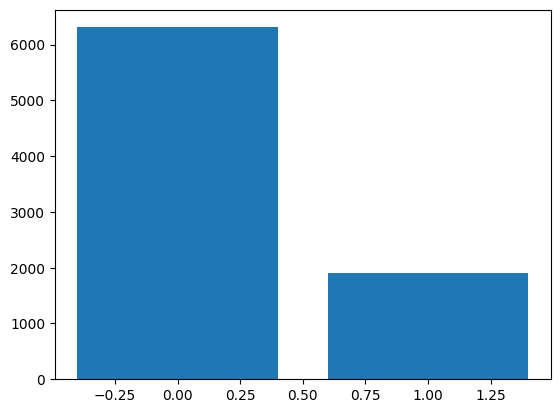

In [ ]:
# Checking distribution of different values in mag_cluster values in barplot 
plt.bar(np.arange(2), rad['rad_cluster'].value_counts().values, align='center') 

### 5.3 Adding clusters to original data

In [ ]:
# Adding the clusters to the original dataframe
df['mag_cluster'] = mag['mag_cluster']
df['rad_cluster'] = rad['rad_cluster']
df.head()

,time,battery,temperature,x,y,z,0_radar,1_radar,2_radar,3_radar,...,dr,snr,rssi,date,hour,day_of_week,day_name,package_type_encoded,mag_cluster,rad_cluster
0,2024-02-13 11:40:00.269,3.04,14.12,511,-736,-374,37,10,7,9,...,1,11.0,-102,2024-02-13,11,1,Tuesday,0,0,0
1,2024-02-13 11:53:29.469,3.04,15.25,126,-683,-436,9,8,4,4,...,1,9.8,-104,2024-02-13,11,1,Tuesday,0,0,0
2,2024-02-13 12:07:58.602,3.04,16.00,35,-696,-382,25,11,4,4,...,1,1.0,-95,2024-02-13,12,1,Tuesday,0,0,0
3,2024-02-13 12:17:58.250,3.04,16.00,27,-697,-379,22,12,6,6,...,1,9.0,-102,2024-02-13,12,1,Tuesday,1,0,0
4,2024-02-13 12:28:00.250,3.04,16.50,26,-696,-370,22,12,6,6,...,1,9.0,-102,2024-02-13,12,1,Tuesday,1,0,0


We'll also make a new column showing the difference between the two clusterings

In [ ]:
# Cluster is different
df['dif_cluster'] = df['mag_cluster'] == df['rad_cluster']

<BarContainer object of 2 artists>

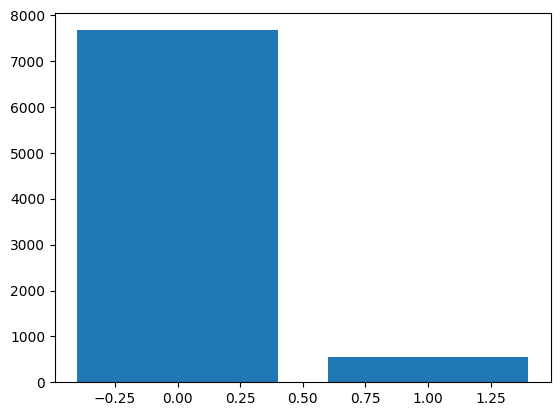

In [ ]:
plt.bar(np.arange(2), df['dif_cluster'].value_counts().values, align='center') 